## Mean Reversion Trading

In [168]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [166]:
import pandas as pd
import torch 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
plt.rcParams["figure.figsize"] = (20, 10)
import datetime
import yfinance as yf
import quantstats as qs

In [58]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('monokai')

In [59]:
Stocks=pd.read_csv('ind_nifty200list.csv')

In [60]:
Stocks['Symbol'] = Stocks['Symbol'].apply(lambda x: x + ".NS" if not x.endswith(".NS") else x)


In [61]:
Stocks['Industry']

0                          Capital Goods
1                 Construction Materials
2                     Financial Services
3                             Healthcare
4                                  Power
                     ...                
195               Information Technology
196                   Financial Services
197    Media Entertainment & Publication
198                    Consumer Services
199                           Healthcare
Name: Industry, Length: 200, dtype: object

In [62]:
stock_list=(Stocks['Symbol']).to_list()

In [63]:
Nifty100data=pd.read_csv('nifty_100_updated.csv')
Nifty100data=Nifty100data.set_index('date')
Nifty100data.index=pd.to_datetime(Nifty100data.index, utc=False)
Nifty100data.columns=Nifty100data.columns+str('.NS')

In [64]:
correlation=Nifty100data

In [65]:
correlation=correlation.dropna()

In [66]:
Stocks = Stocks[Stocks['Symbol'].isin(correlation.columns)]
Stocks=Stocks.reset_index()

In [67]:
Valid_pairs=[]
for i in range(len(Stocks)):
    for j in range(len(Stocks)):
        if((Stocks['Industry'][i]==Stocks['Industry'][j]) & (Stocks['Symbol'][i]!=Stocks['Symbol'][j])):
            Valid_pairs.append((Stocks['Symbol'][i],Stocks['Symbol'][j],Stocks['Industry'][i],Stocks['Industry'][j]))

In [68]:
ValidPairs=pd.DataFrame(Valid_pairs,columns=['Stock1','Stock2','Industry1','Industry2'])

In [69]:
unique_dates=(sorted(list(set(correlation.index.date))))

In [70]:
len(unique_dates)

493

In [71]:

def GetRelevantPairs(Look_back_DataFrame, threshold, ValidPairs):
    lst = []
    checked_pairs = set()  # To keep track of checked pairs
    first_values_set = set()  # To keep track of unique first values

    for i in range(len(ValidPairs)):
        stock1 = ValidPairs['Stock1'][i]
        stock2 = ValidPairs['Stock2'][i]

        # Ensure that stock1 and stock2 are in the same order (a, b)
        pair = (stock1, stock2) if stock1 < stock2 else (stock2, stock1)

        # Check if the pair has already been processed
        if pair not in checked_pairs:
            stock1_data = Look_back_DataFrame[stock1]
            stock2_data = Look_back_DataFrame[stock2]
            
            p_value = coint(stock1_data, stock2_data)[1]
            corr_value = stock1_data.corr(stock2_data)

            if p_value <= threshold and corr_value > 0:
                lst.append((stock1, stock2, p_value))

            # Mark the pair as checked
            checked_pairs.add(pair)

            # Track the first value in the pair
            first_values_set.add(pair[0])

    # Sort the list based on the ascending order of the last item (p_value) in each sublist
    lst = sorted(lst, key=lambda x: x[2])

    # Drop duplicates based on the first value
    unique_pairs = []
    for pair in lst:
        if pair[0] in first_values_set:
            unique_pairs.append(pair)
            first_values_set.remove(pair[0])  # Remove the first value to avoid duplicates

    # Select the top values
    top_5_pairs = unique_pairs[:10]

    return top_5_pairs


In [72]:
import pandas as pd

def create_ratio_dataframe(stock1,stock2,Look_back_DataFrame):
    df=Look_back_DataFrame[[stock1,stock2]]
    ratio_df = pd.DataFrame()

    for i, stock1 in enumerate(df.columns):
        for j, stock2 in enumerate(df.columns):
            if i < j:  # Avoid duplicates
                ratio_name = f'{stock1}/{stock2}'
                if ratio_name not in ratio_df.columns:
                    ratio = df[stock1] / df[stock2]
                    ratio_df[ratio_name] = ratio

                # Add individual stock1 and stock2 data with column names as stock symbols
                ratio_df[stock1] = df[stock1]
                ratio_df[stock2] = df[stock2]

    return ratio_df



In [73]:
def calculate_adf_statistic(ratio_df):
    rolling_window = 200
    adf_results = []
    ratio_data = []
    stock1_prices = []
    stock2_prices = []
    stock_symbols = ratio_df.columns[0].split('/')
    stock1, stock2 = stock_symbols[0], stock_symbols[1]
    for i in range(rolling_window, len(ratio_df)):
        rolling_data = ratio_df[ratio_df.columns[0]].iloc[i - rolling_window:i]
        result = [1,0]

        
        
        stock1_prices.append(ratio_df[stock1].iloc[i])
        stock2_prices.append(ratio_df[stock2].iloc[i])

        adf_results.append(result[0])
        ratio_data.append(ratio_df[ratio_df.columns[0]].iloc[i])

    adf_statistic_df = pd.DataFrame({
        'Ratio Data': ratio_data,
        'ADF Statistic': adf_results,
        f'{stock_symbols[0]}': stock1_prices,
        f'{stock_symbols[1]}': stock2_prices
    }, index=ratio_df.index[rolling_window:])

    rolling_mean = adf_statistic_df['Ratio Data'].rolling(window=rolling_window).mean()
    rolling_std = adf_statistic_df['Ratio Data'].rolling(window=rolling_window).std()

    adf_statistic_df['Rolling Mean'] = rolling_mean
    adf_statistic_df['1x Std'] = rolling_mean + rolling_std
    adf_statistic_df['1.5x Std'] = rolling_mean + 1.5 * rolling_std
    adf_statistic_df['2x Std'] = rolling_mean + 2 * rolling_std
    adf_statistic_df['2.5x Std'] = rolling_mean + 2.5 * rolling_std
    adf_statistic_df['3x Std'] = rolling_mean + 3 * rolling_std

    adf_statistic_df['-1x Std'] = rolling_mean - rolling_std
    adf_statistic_df['-1.5x Std'] = rolling_mean - 1.5 * rolling_std
    adf_statistic_df['-2x Std'] = rolling_mean - 2 * rolling_std
    adf_statistic_df['-2.5x Std'] = rolling_mean - 2.5 * rolling_std
    adf_statistic_df['-3x Std'] = rolling_mean - 3 * rolling_std
    
    adf_statistic_df=adf_statistic_df.rename_axis("Datetime")
    return adf_statistic_df

In [74]:
import pandas as pd
import datetime

def apply_trading_rules(adf_statistic_df):
    # Define the conditions
    condition_2 = ((adf_statistic_df['Ratio Data'] > adf_statistic_df['2x Std']))
    condition_3 = ((adf_statistic_df['Ratio Data'] < adf_statistic_df['-2x Std']))

    adf_statistic_df['Marker'] = 0

    # Update 'Marker' column where condition_1 and condition_2 hold to -1
    adf_statistic_df.loc[condition_2, 'Marker'] = -1

    # Update 'Marker' column where condition_1 and condition_3 hold to 1
    adf_statistic_df.loc[condition_3, 'Marker'] = 1

    # Define the start and end indices for the slice
    indices = adf_statistic_df.loc[adf_statistic_df['Marker'] != 0].index

    adf_statistic_df.reset_index(inplace=True)
    flag = 0
    in_trade = False

    # Define the cutoff time
    cutoff_time = datetime.time(15, 10)

    # Iterate through the DataFrame
    for index, row in adf_statistic_df.iterrows():
        if in_trade:
            if flag == 1 and ((row['Ratio Data'] > row['Rolling Mean']) or row['Datetime'] >= pd.Timestamp.combine(row['Datetime'].date(), cutoff_time).tz_localize('Asia/Kolkata')):
                adf_statistic_df.at[index, 'Marker'] = 2  # Exit the long trade
                in_trade = False
            elif flag == -1 and ((row['Ratio Data'] < row['Rolling Mean']) or row['Datetime'] >= pd.Timestamp.combine(row['Datetime'].date(), cutoff_time).tz_localize('Asia/Kolkata')):
                adf_statistic_df.at[index, 'Marker'] = 2  # Exit the short trade
                in_trade = False
            else:
                adf_statistic_df.at[index, 'Marker'] = 0  # Continue in the trade
        elif row['Datetime'].time() <= cutoff_time:
            if row['Marker'] == 1:
                flag = 1
                adf_statistic_df.at[index, 'Marker'] = 1  # Enter long trade
                in_trade = True
            elif row['Marker'] == -1:
                flag = -1
                adf_statistic_df.at[index, 'Marker'] = -1  # Enter short trade
                in_trade = True
            else:
                adf_statistic_df.at[index, 'Marker'] = 0  # No trade
        else:
            adf_statistic_df.at[index, 'Marker'] = 0  # No trade after cutoff time

    return adf_statistic_df




In [131]:
import pandas as pd
import numpy as np
import datetime

def calculate_trading_profits(adf_statistic_df):
    # Define the conditions
    condition_2 = ((adf_statistic_df['Ratio Data'] > adf_statistic_df['2x Std']))
    condition_3 = ((adf_statistic_df['Ratio Data'] < adf_statistic_df['-2x Std']))

    adf_statistic_df['Marker'] = 0

    # Update 'Marker' column where condition_1 and condition_2 hold to -1
    adf_statistic_df.loc[condition_2, 'Marker'] = -1

    # Update 'Marker' column where condition_1 and condition_3 hold to 1
    adf_statistic_df.loc[condition_3, 'Marker'] = 1

    adf_statistic_df.reset_index(inplace=True)
    flag = 0
    in_trade = False

    # Define the cutoff time
    cutoff_time = datetime.time(15, 10)

    # Iterate through the DataFrame
    for index, row in adf_statistic_df.iterrows():
        if in_trade:
            if flag == 1 and ((row['Ratio Data'] > row['Rolling Mean']) or row['Datetime'] >= pd.Timestamp.combine(row['Datetime'].date(), cutoff_time).tz_localize('Asia/Kolkata')):
                adf_statistic_df.at[index, 'Marker'] = 2  # Exit the long trade
                in_trade = False
            elif flag == -1 and ((row['Ratio Data'] < row['Rolling Mean']) or row['Datetime'] >= pd.Timestamp.combine(row['Datetime'].date(), cutoff_time).tz_localize('Asia/Kolkata')):
                adf_statistic_df.at[index, 'Marker'] = 2  # Exit the short trade
                in_trade = False
            else:
                adf_statistic_df.at[index, 'Marker'] = 0  # Continue in the trade
        elif row['Datetime'].time() <= cutoff_time:
            if row['Marker'] == 1:
                flag = 1
                adf_statistic_df.at[index, 'Marker'] = 1  # Enter long trade
                in_trade = True
            elif row['Marker'] == -1:
                flag = -1
                adf_statistic_df.at[index, 'Marker'] = -1  # Enter short trade
                in_trade = True
            else:
                adf_statistic_df.at[index, 'Marker'] = 0  # No trade
        else:
            adf_statistic_df.at[index, 'Marker'] = 0  # No trade after cutoff time

    resultant_df = adf_statistic_df.loc[adf_statistic_df['Marker'] != 0]
    profits = []

    for i in range(0, len(resultant_df) - 1, 2):
        entry_index = resultant_df.index[i]
        exit_index = resultant_df.index[i + 1]

        if resultant_df['Marker'][entry_index] == 1:
            stock1_sell = resultant_df[resultant_df.columns[3]][exit_index]
            stock1_buy = resultant_df[resultant_df.columns[3]][entry_index]
            stock2_sell = resultant_df[resultant_df.columns[4]][entry_index]
            stock2_buy = resultant_df[resultant_df.columns[4]][exit_index]
            
            profit = 2.5 * ((stock1_sell - stock1_buy) / stock1_buy + (stock2_sell - stock2_buy) / stock2_buy)
            profits.append(profit)

        if resultant_df['Marker'][entry_index] == -1:
            stock1_sell = resultant_df[resultant_df.columns[3]][entry_index]
            stock1_buy = resultant_df[resultant_df.columns[3]][exit_index]
            stock2_sell = resultant_df[resultant_df.columns[4]][exit_index]
            stock2_buy = resultant_df[resultant_df.columns[4]][entry_index]
            
            profit = 2.5 * ((stock1_sell - stock1_buy) / stock1_buy + (stock2_sell - stock2_buy) / stock2_buy)
            profits.append(profit)

    # Adjust profits for trading costs
    profits = np.array(profits) - ( 0.000323)

    return profits

# Example usage:
# total_profits = calculate_trading_profits(adf_statistic_df)


In [191]:
SampleWise=[]
Pair_Statistics=[]

In [ ]:
for j in range(40,41):
    FullTimeReturns = []
    
    for k in range(0    ,len(unique_dates) - (j + 1)):
        daily_gains = 0
        Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
        Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]

        ValidTradingPairs = GetRelevantPairs(Look_back_DataFrame, 0.05, ValidPairs)

        NextDayPairs = [(pair[0], pair[1]) for pair in ValidTradingPairs]
        num_pairs = len(NextDayPairs)  # Number of pairs
        
        non_zero_gains_count = 0  # Count of pairs with non-zero gains
        
        for i in range(num_pairs):
            pair = NextDayPairs[i]
            stock1 = pair[0]
            stock2 = pair[1]
            ratio_df = create_ratio_dataframe(stock1, stock2, Trading_DataFrame)
            adf_statistic_df = calculate_adf_statistic(ratio_df)
            adf_statistic_df = adf_statistic_df.loc[adf_statistic_df.index.date == unique_dates[j + k]]
            gains = calculate_trading_profits(adf_statistic_df) / 10
            
            # Check if len(NextDayPairs) and gains are not zero before adding to daily_gains
            if num_pairs != 0 and len(gains) != 0:
                daily_gains += np.sum(gains)
                non_zero_gains_count += 1
        
        Pair_Statistics.append((unique_dates[j + k],len(NextDayPairs),non_zero_gains_count))
        FullTimeReturns.append(daily_gains)
        
        # Now, you have additional information for this iteration
        print("Iteration number:", k)
        print("Number of Pairs:", num_pairs)
        print("Pairs Traded:", non_zero_gains_count)
        print("Profit for the day:", daily_gains)

        

SampleWise.append((j, FullTimeReturns))


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 0
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: 0.013008893831242832


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 1
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: -0.006187980167023082


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 2
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: -0.004019682429110626


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 3
Number of Pairs: 10
Pairs Traded: 8
Profit for the day: 0.0016663643424863893


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 4
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: -0.03576443583259008


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 5
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: -0.0046665515939075305


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 6
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: 0.010561372588024046


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 7
Number of Pairs: 10
Pairs Traded: 9
Profit for the day: -0.01784817887126311


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 8
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: 0.0032900680819980504


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 9
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: -0.008571003377892142


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 10
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: -0.011548895381911452


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 11
Number of Pairs: 10
Pairs Traded: 9
Profit for the day: 0.0012774070338673334


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 12
Number of Pairs: 10
Pairs Traded: 9
Profit for the day: 0.010315760796383355


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 13
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: -0.008449532968402174


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 14
Number of Pairs: 10
Pairs Traded: 9
Profit for the day: -0.003674812197328201


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 15
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: 0.005429986465124553


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 16
Number of Pairs: 10
Pairs Traded: 9
Profit for the day: 0.004323975480739349


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 17
Number of Pairs: 10
Pairs Traded: 8
Profit for the day: -0.002290885436176624


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


Iteration number: 18
Number of Pairs: 10
Pairs Traded: 10
Profit for the day: 0.006819688009193195


C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Look_back_DataFrame = correlation[unique_dates[0 + k]:unique_dates[j + k]]
C:\Users\Sohum\AppData\Local\Temp\ipykernel_23128\3767477283.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  Trading_DataFrame = correlation.loc[unique_dates[(j + 1) - 4 + k]:unique_dates[(j + 1) + k]]


In [ ]:
indexes=[]
for k in range(len(unique_dates)-(j+1)):
        indexes.append(unique_dates[j+k])

In [174]:
returns_series_aligned = pd.Series(FullTimeReturns, index=indexes)


In [175]:
returns_series_aligned.index=pd.to_datetime(returns_series_aligned.index)

In [171]:
quantStats=pd.Series(returns_series_aligned)

In [121]:
MarketReturns= yf.download(tickers=['^NSEI'],start='2021-10-20',end=indexes[-1])['Close']
MarketReturns=MarketReturns.pct_change().dropna()
#MarketReturns=np.cumprod(1+MarketReturns).dropna()

[*********************100%***********************]  1 of 1 completed


In [177]:
qs.reports.html(quantStats,MarketReturns)


In [254]:
quantStats.index

DatetimeIndex(['2021-10-21', '2021-10-22', '2021-10-25', '2021-10-26',
               '2021-10-27', '2021-10-28', '2021-10-29', '2021-11-01',
               '2021-11-02', '2021-11-03',
               ...
               '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-18',
               '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-25',
               '2023-09-26', '2023-09-27'],
              dtype='datetime64[ns]', length=480, freq=None)

In [40]:
import quantstats as qs

In [249]:
qs.reports.html(quantStats)

In [178]:
PairStatistics=(pd.DataFrame(Pair_Statistics,columns=['Date','Pairs shortlisted for the day','Pairs traded in']))

In [179]:
PairStatistics['Returns']=0

In [180]:
PairStatistics['Returns']=FullTimeReturns

In [181]:
(PairStatistics).to_csv('10 pairs no ADF 30 day lookback and 2std.csv')

Mean Portfolio Value: 1815862.02
Median Portfolio Value: 1804975.34
Standard Deviation of Portfolio Value: 207683.40
5th Percentile Portfolio Value: 1497137.74
25th Percentile Portfolio Value: 1670503.99
75th Percentile Portfolio Value: 1948912.30
95th Percentile Portfolio Value: 2178509.14


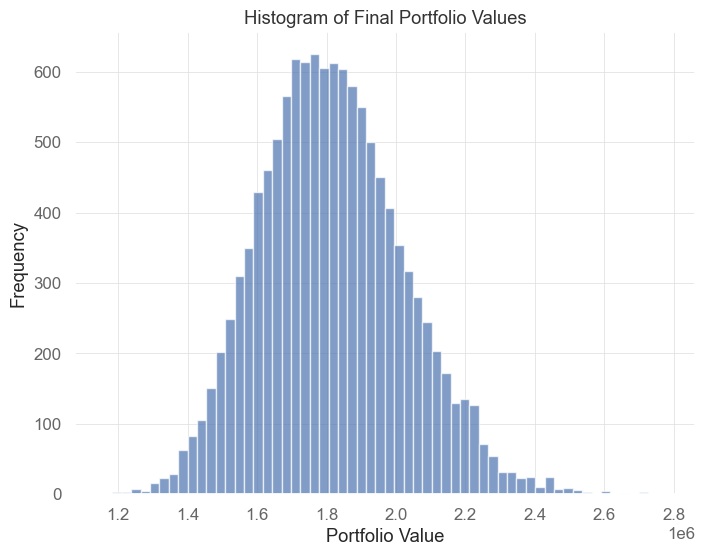

CPU times: total: 2.47 s
Wall time: 4.16 s


In [182]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# Define parameters for Monte Carlo simulation
initial_investment = 1000000  # Initial investment amount
num_simulations = 12000       # Number of simulations
num_days = len(returns_series_aligned)
daily_returns = np.array(returns_series_aligned) / 2

# Create a list to store the different price paths
def monte_carlo_simulation(num_simulations, num_days, daily_returns, initial_investment):
    price_paths = []  # Initialize the list within the function
    for i in range(num_simulations):
        # Generate random daily returns for the simulation
        random_returns = np.random.choice(daily_returns, num_days)
    
        # Calculate the cumulative portfolio value based on random returns
        price_path = (1 + random_returns).cumprod() * initial_investment
    
        # Append the price path to the list
        price_paths.append(price_path)
    
    return price_paths  # Return the list of price paths

# Run the Monte Carlo simulation
price_paths = monte_carlo_simulation(num_simulations, num_days, daily_returns, initial_investment)

# Convert the list of price paths into a DataFrame
simulation_results = pd.DataFrame(price_paths).T

# Rename columns with simulation names
simulation_results.columns = [f"Simulation_{i+1}" for i in range(num_simulations)]

# Calculate and print important statistics
final_portfolio_values = simulation_results.iloc[-1, :]
mean_portfolio_value = final_portfolio_values.mean()
median_portfolio_value = final_portfolio_values.median()
std_dev_portfolio_value = final_portfolio_values.std()
quantiles = final_portfolio_values.quantile([0.05, 0.25, 0.75, 0.95])

print(f"Mean Portfolio Value: {mean_portfolio_value:.2f}")
print(f"Median Portfolio Value: {median_portfolio_value:.2f}")
print(f"Standard Deviation of Portfolio Value: {std_dev_portfolio_value:.2f}")
print(f"5th Percentile Portfolio Value: {quantiles[0.05]:.2f}")
print(f"25th Percentile Portfolio Value: {quantiles[0.25]:.2f}")
print(f"75th Percentile Portfolio Value: {quantiles[0.75]:.2f}")
print(f"95th Percentile Portfolio Value: {quantiles[0.95]:.2f}")

# Create a histogram of final portfolio values
plt.figure(figsize=(8, 6))
plt.hist(final_portfolio_values, bins=60, alpha=0.7)
plt.title("Histogram of Final Portfolio Values")
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.show()


In [186]:
np.cumprod(1+returns_series_aligned)[-1]-1

2.220339530776015

In [190]:
qs.reports.html(returns_series_aligned)